<!-- <img src="images/openfe_logo.png" width="200"> &emsp;&emsp;  -->
<img src="images/OMSF-logo-horizontal-color.png" width="300"> 

# Open Free Energy: An Open Source Ecosystem for Calculating Free Energies

## The ``Hello, World!`` of Free Energy Calculations


The OpenFE ecosystem is an open-source framework for calculating alchemical free energies.

In this demo, we will demonstrate how you can use either the CLI or Python API to execute physics-based simulations and predict the relative binding free energy (RBFE) of a ligand binding to a protein.

Specifically, we will be predicting which ligand from a set of candidates binds best to a target protein. We will be using TYK2 (Tyrosine kinase 2) as our target protein, which can be thought of as the "Hello, World" of free energy calculations.

For convenience, a prepared (capped and protonated) PDB structure of the
TYK2 protein is provided under `inputs/tyk2_protein.pdb`:
<figure>
    <img src="images/tyk2.png" width="200" alt="TYK2 protein">
    <!-- <figcaption align="top"> TYK2 protein</figcaption> -->
</figure>

## Overview
RBFE calculations can be thought of as 3 distinct steps:

 1. **Setup**: construct a graph relating the ligands
 2. **Run**: execute a physics-based simulation
 3. **Gather**: compute meaningful metrics from the simulation data

Each stage is supported by the OpenFE software packages, but everything can be accessed from the base **openfe** package.

<img src="images/ecosystem.png" width="500">

**NOTE**: OpenFE's RBFE protocol uses [OpenMM](https://openmm.org/) as the physics based simulation engine.
<!-- **NOTE**: OpenFE also provides protocols for running [Absolute Hydration Free Energy Calculations](https://docs.openfree.energy/en/latest/tutorials/ahfe_tutorial.html) and [Molecular Dynamics (MD) simulations](https://docs.openfree.energy/en/latest/tutorials/md_tutorial.html). 
Also, see our [tutorials](https://docs.openfree.energy/en/stable/tutorials/index.html) for step-by-step guides. -->

## Outline

0. Setup for Google Colab  
1. Quick Start: Relative Free Energies with the OpenFE CLI
2. Setup  
    2.1. Loading Ligands and Defining Ligand Atom Mappings  
    2.2. Creating a ligand network  
    2.3. Defining ChemicalSystems  
    2.4. Defining the RBFE simulation settings and protocol  
3. Running a Relative Ligand Binding Free Energy Calculation  
    3.1. Using the Python API  
    3.2. Using the CLI 
4. Gather & Analysis

# 0. Setup for Google Colab

If you are running this example in Google Colab, run the following cells to setup the environment.\
If you are running this notebook locally, skip down to `1. Quick Start`

In [3]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"  # hack for google colab, not needed for local execution

if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -q condacolab
    import condacolab
    condacolab.install_from_url("https://github.com/OpenFreeEnergy/openfe/releases/download/v1.6.0/OpenFEforge-1.6.0-Linux-x86_64.sh")

In [2]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    import condacolab
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mkdir inputs && cd inputs && openfe fetch rbfe-tutorial
    for _ in range(3):
      # Sometimes we have to re-run the check
      try:
        condacolab.check()
      except:
        pass
      else:
        break

# 1. Relative Binding Free Energies with the **openfe** CLI

First, we'll show how you can run a basic RBFE campaign with no Python at all!

The 3 stages described above each correspond to a CLI command:

**1. setup**:``openfe plan-rbfe-network``

**2. run** ``openfe quickrun``

**3. gather** ``openfe gather``

All you need is your target protein in `.pdb` format, and your candidate ligands in `.sdf` format.

## 1.1 Setup

The `openfe plan-rbfe-network` command plans a relative binding free energy network and saves it as a series of JSON files for the `openfe quickrun` command to process.

Since the CLI tool is a wrapper intended for the simplest cases, it chooses pratical defaults so that you don't have to define them. 
<!-- # TODO: add link to defaults -->

These choices can be customized by creating a settings yaml file, which is
passed in via the ``-s settings.yaml`` option. For more details, please visit our user guide section about [Customising CLI planning with YAML settings](https://docs.openfree.energy/en/latest/guide/cli/cli_yaml.html)

In [3]:
# note, we use ligands with charges already assigned to speed up this step, but this is optional
! openfe plan-rbfe-network -M inputs/tyk2_ligands_charged.sdf -p inputs/tyk2_protein.pdb -o tyk2_campaign

RBFE-NETWORK PLANNER
______________________

Parsing in Files: 
	Got input: 
		Small Molecules: SmallMoleculeComponent(name=lig_ejm_31) SmallMoleculeComponent(name=lig_ejm_42) SmallMoleculeComponent(name=lig_ejm_46) SmallMoleculeComponent(name=lig_ejm_43) SmallMoleculeComponent(name=lig_ejm_47) SmallMoleculeComponent(name=lig_ejm_50) SmallMoleculeComponent(name=lig_jmc_23) SmallMoleculeComponent(name=lig_ejm_48) SmallMoleculeComponent(name=lig_jmc_27) SmallMoleculeComponent(name=lig_jmc_28)
		Protein: ProteinComponent(name=)
		Cofactors: []
		Solvent: SolventComponent(name=O, Na+, Cl-)

Using Options:
	Mapper: <LomapAtomMapper (time=20, threed=True, max3d=1.0, element_change=True, seed='', shift=False)>
	Mapping Scorer: <function default_lomap_score at 0x17b8fcf40>
	Network Generation: <function generate_minimal_spanning_network at 0x17c99c360>
	Partial Charge Generation: am1bcc

	n_protocol_repeats=3 (3 simulation repeat(s) per transformation)

Planning RBFE-Campaign:
assigning ligand

### visualizing the network

We can visualize the network stored in `ligand_network.graphml` using the `openfe view-ligand-network` command:

In [4]:
! ls tyk2_campaign/

ligand_network.graphml transformations        tyk2_campaign.json


In [5]:
!openfe view-ligand-network tyk2_campaign/ligand_network.graphml

In [6]:
! ls tyk2_campaign/transformations/

rbfe_lig_ejm_31_complex_lig_ejm_46_complex.json
rbfe_lig_ejm_31_complex_lig_ejm_47_complex.json
rbfe_lig_ejm_31_complex_lig_ejm_48_complex.json
rbfe_lig_ejm_31_complex_lig_ejm_50_complex.json
rbfe_lig_ejm_31_solvent_lig_ejm_46_solvent.json
rbfe_lig_ejm_31_solvent_lig_ejm_47_solvent.json
rbfe_lig_ejm_31_solvent_lig_ejm_48_solvent.json
rbfe_lig_ejm_31_solvent_lig_ejm_50_solvent.json
rbfe_lig_ejm_42_complex_lig_ejm_43_complex.json
rbfe_lig_ejm_42_complex_lig_ejm_50_complex.json
rbfe_lig_ejm_42_solvent_lig_ejm_43_solvent.json
rbfe_lig_ejm_42_solvent_lig_ejm_50_solvent.json
rbfe_lig_ejm_46_complex_lig_jmc_28_complex.json
rbfe_lig_ejm_46_solvent_lig_jmc_28_solvent.json
rbfe_lig_jmc_23_complex_lig_jmc_28_complex.json
rbfe_lig_jmc_23_solvent_lig_jmc_28_solvent.json
rbfe_lig_jmc_27_complex_lig_jmc_28_complex.json
rbfe_lig_jmc_27_solvent_lig_jmc_28_solvent.json


## 1.2 Run

You can run each leg individually by using the `openfe quickrun` command. It takes a transformation JSON as input, and the flags `-o` to give the final output JSON file and `-d` for the directory where simulation results should be stored. For example,

```bash
openfe quickrun tyk2_json/lig_ejm_31_lig_ejm_47_complex.json -o results_complex.json -d working-directory
openfe quickrun tyk2_json/lig_ejm_31_lig_ejm_47_solvent.json -o results_solvent.json -d working-directory
```

Molecular simulation is time-intensive, so instead of running on high-performance compute, you can copy down example results to explore the next step:

In [7]:
# Results from our cli tutorial
!openfe fetch rbfe-tutorial-results
# Extract results
!tar -xf rbfe_results.tar.gz

Fetching /Users/atravitz/micromamba/envs/openfe_conda/lib/python3.13/site-packages/openfecli/tests/data/rbfe_results.tar.gz


## 1.3 Gather

Once the simulations are complete, you can use `openfe gather` to calculate the $\Delta G$ values for each ligand:

In [8]:
!openfe gather results/ --report raw

┌─────────┬────────────┬────────────┬─────────────────────┬────────────────────┐
│         │            │            │                     │ MBAR uncertainty   │
│ leg     │ ligand_i   │ ligand_j   │ DG(i->j) (kcal/mol) │ (kcal/mol)         │
├─────────┼────────────┼────────────┼─────────────────────┼────────────────────┤
│ complex │ lig_ejm_31 │ lig_ejm_42 │ -14.8               │ 0.8                │
│ complex │ lig_ejm_31 │ lig_ejm_42 │ -14.9               │ 0.8                │
│ complex │ lig_ejm_31 │ lig_ejm_42 │ -15.1               │ 0.8                │
│ solvent │ lig_ejm_31 │ lig_ejm_42 │ -15.7               │ 0.8                │
│ solvent │ lig_ejm_31 │ lig_ejm_42 │ -15.7               │ 0.8                │
│ solvent │ lig_ejm_31 │ lig_ejm_42 │ -15.7               │ 0.8                │
│ complex │ lig_ejm_31 │ lig_ejm_46 │ -40.7               │ 0.8                │
│ complex │ lig_ejm_31 │ lig_ejm_46 │ -40.7               │ 0.8                │
│ complex │ lig_ejm_31 │ lig

In [5]:
!openfe gather results/ 

┌────────────┬────────────────────┬────────────────────────┐
│ ligand     │ DG(MLE) (kcal/mol) │ uncertainty (kcal/mol) │
├────────────┼────────────────────┼────────────────────────┤
│ lig_ejm_31 │ -0.09              │ 0.05                   │
│ lig_ejm_42 │ 0.7                │ 0.1                    │
│ lig_ejm_46 │ -0.98              │ 0.05                   │
│ lig_ejm_47 │ -0.1               │ 0.1                    │
│ lig_ejm_48 │ 0.53               │ 0.09                   │
│ lig_ejm_50 │ 0.91               │ 0.06                   │
│ lig_ejm_43 │ 2.0                │ 0.2                    │
│ lig_jmc_23 │ -0.68              │ 0.09                   │
│ lig_jmc_27 │ -1.1               │ 0.1                    │
│ lig_jmc_28 │ -1.25              │ 0.08                   │
└────────────┴────────────────────┴────────────────────────┘


# 2. Now Let's Do It Again - In Python!


Here is what we will achieve in this notebook and what software toolchains are
used along the way.
 

| **Actions**                    | **Software**                                                |
|:------------------------------|:-----------------------------------------------------------|
| Create OpenFE Molecules        | OpenFE  RDKit                                            |
| Create Network                 | OpenFE  Lomap, Networkx                                  |
| Visualize Network              | OpenFE  NetworkX, RDKit, Matplotlib                      |
| Create ligand topologies       | OpenFE interface - OpenFF tk                             |
| Create Hybrid OpenMM topology  | OpenFE interface - OpenMMTools (eventually - ex Perses)  |
| Create Lambda Protocol         | OpenFE interface - OpenMMTools (eventually - ex Perses)  |
| Set up and run RBFE calculations | OpenFE interface - OpenMM + OpenMMTools                  |
| Analyze RBFE calculations      | OpenFE interface - PyMBAR + OpenMMTools                  |

## 2.1: Setup


### 2.1.1: Loading Ligands and Defining Ligand Atom Mappings

#### Creating OpenFE SmallMoleculeComponents

To keep track of the various inputs being passed through the OpenFE
toolkit, OpenFE implements a set of [Components](https://gufe.openfree.energy/en/latest/concepts/included_models.html#component) which define the proteins,
small molecules, and solvent components of a chemical system.

Here we use the [SmallMoleculeComponent](https://github.com/OpenFreeEnergy/gufe/blob/main/gufe/components/smallmoleculecomponent.py)
which can be defined from [RDKit molecules](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html)
or [OpenFF molecules](https://open-forcefield-toolkit.readthedocs.io/en/0.9.2/api/generated/openff.toolkit.topology.Molecule.html).

In the backend, OpenFE uses RDKit molecules as the central representation
of the ligands, and uses the OpenFF toolkit to convert between objects from
various toolchains (for example [OpenEye's OEMol](https://docs.eyesopen.com/toolkits/python/oechemtk/OEChemClasses/OEMol.html)).

Here we demonstrate how to load the ligands from `inputs/tyk2_ligands.sdf` into a
list of OpenFE `SmallMoleculeComponent`s for further processing.

<u>Load ligands using RDKit:</u>

In [5]:
from openfe import SmallMoleculeComponent
from rdkit import Chem

# Load ligands using RDKit
ligands_sdf = Chem.SDMolSupplier('inputs/tyk2_ligands.sdf', removeHs=False)

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent(sdf) for sdf in ligands_sdf]

<u>Load ligands using the OpenFF toolkit:</u>

In [6]:
from openff.toolkit import Molecule
from openfe import SmallMoleculeComponent

# Load ligands using OpenFF toolkit
ligands_sdf = Molecule.from_file('inputs/tyk2_ligands.sdf')

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent.from_openff(sdf) for sdf in ligands_sdf]


OpenFE `SmallMoleculeComponent`s have some useful built-in attributes and methods.

For example, the molecule's name (as defined by the SDF file) can be accessed:

In [7]:
print("name: ", ligand_mols[0].name)

name:  lig_ejm_31


As previously stated, `SmallMoleculeComponent`s also use the OpenFF backend to allow conversion between different object types.

For example, it's possible to obtain an OpenFF representation of a Molecule:

In [8]:
type(ligand_mols[0].to_openff()), ligand_mols[0].to_openff(), ligand_mols[0]

(openff.toolkit.topology.molecule.Molecule,
 Molecule with name 'lig_ejm_31' and SMILES '[H][c]1[n][c]([N]([H])[C](=[O])[C]([H])([H])[H])[c]([H])[c]([N]([H])[C](=[O])[c]2[c]([Cl])[c]([H])[c]([H])[c]([H])[c]2[Cl])[c]1[H]',
 SmallMoleculeComponent(name=lig_ejm_31))

### 2.1.2: Ligand Atom Mapping

In the [RBFE protocol](https://docs.openfree.energy/en/latest/guide/protocols/relativehybridtopology.html) , an atom mapping defines which atoms are mutated during the alchemical transformation.
The user can choose between two different atom S:
1. `LomapAtomMapper`: based on the maximum common substructure (MCS)
2. `KartografAtomMapper`: based on the 3D geometries of the ligands

While we use the defaults here, please note that any supported arguments of Lomap and Kartograf can be passed to the atom mapper.

**1. `LomapAtomMapper`** 

In [9]:
from openfe.setup import LomapAtomMapper
mapper = LomapAtomMapper()
lomap_mapping = next(mapper.suggest_mappings(ligand_mols[0], ligand_mols[4]))

We can also visualize the atom mappings by invoking the individual OpenFE `AtomMapping` objects directly.

Unique atoms between each mapping are shown in red, and atoms which are mapped but undergo element changes are shown in blue. Bonds which either involve atoms that are unique or undergo element changes are highlighted in red.

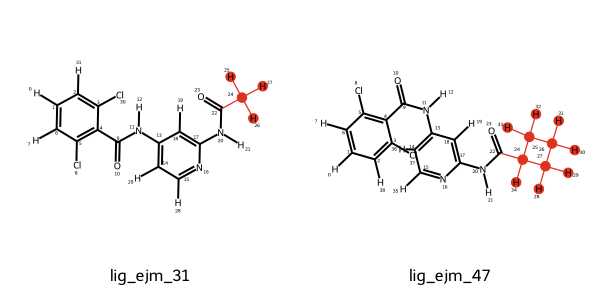

In [10]:
# We can display the atom mapping in 2D by calling it
lomap_mapping

It is also possible to visualize the mapping in 3D using py3dmol:

Here, the ``visualization_3D`` method displays the two end state molecules (left and right), in addition to the hybrid molecule (middle).

Atoms that have the same sphere color in both end states are mapped (i.e. will be interpolated between each other), whilst those that do not have a coloured sphere are unmapped (i.e. will be transformed into dummy atoms in the opposite end state).

In [16]:
# Visualize the mapping in 3D
from openfe.utils import visualization_3D

visualization_3D.view_mapping_3d(lomap_mapping, show_atomIDs=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**2. `KartografAtomMapper`**

We can also use the `KartografAtomMapper` which is based on the 3D geometries of the ligands.

In [13]:
from kartograf import KartografAtomMapper
# Build Kartograf Atom Mapper
mapper = KartografAtomMapper(atom_map_hydrogens=True)

# Get Mapping
kartograf_mapping = next(mapper.suggest_mappings(ligand_mols[0], ligand_mols[4]));

INFO:	#################################
INFO:	Map Heavy Atoms 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	#################################
INFO:	Map Hydrogen Atoms: 
INFO:	#################################
INFO:	Masking Atoms
INFO:	Build Distance Matrix
INFO:	Calculate Mapping
INFO:	Find Maximal overlapping connected sets of mapped atoms
INFO:	Filtering bond breaks


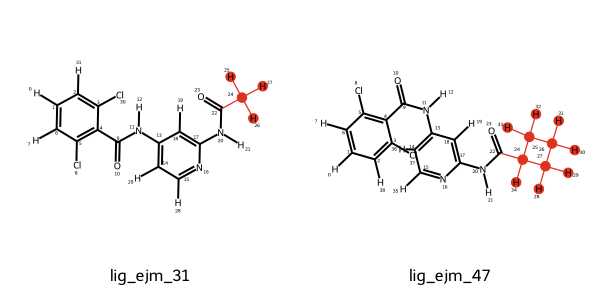

In [14]:
# We can display the atom mapping in 2D by calling it
kartograf_mapping

In [15]:
# Visualize the mapping in 3D
from openfe.utils import visualization_3D

visualization_3D.view_mapping_3d(kartograf_mapping, show_atomIDs=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### 2.1.3: Creating a ligand network


A `LigandNetwork` is a set of `SmallMoleculeComponent`s that are connected by `AtomMapping`s of two small molecules. 

The user can choose between multiple different network topologies:
* Minimial spanning tree (MST)
* LOMAP network
* Radial (star) network
* Loading in networks from external software (FEP+ or Orion)
* Loading in a user-defined network

In this section, we will create and visualize the MST, LOMAP, and radial networks for the TYK2 dataset.

Here, we will be using the `LomapAtomMapper` as the atom mapper for all networks.

In [38]:
# Create network from the two molecules
import openfe
from openfe.setup.ligand_network_planning import generate_radial_network
from openfe.setup.ligand_network_planning import generate_minimal_spanning_network
from openfe.setup.ligand_network_planning import generate_lomap_network
from openfe.setup import LomapAtomMapper

# Create an MST network
mst_network = generate_minimal_spanning_network(
    ligands=ligand_mols,
    scorer=openfe.lomap_scorers.default_lomap_score,
    mappers=[LomapAtomMapper(),]);

# Create a LOMAP network
lomap_network = generate_lomap_network(
    ligands=ligand_mols,
    scorer=openfe.lomap_scorers.default_lomap_score,
    mappers=[LomapAtomMapper(),]);

INFO:	Trying to remove edge 0-2 with similarity 0.818731
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 0-2
INFO:	Trying to remove edge 2-6 with similarity 0.860708
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 0-1 with similarity 0.904837
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 0-6 with similarity 0.904837
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 1-2 with similarity 0.904837
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 1-6 with similarity 0.951229
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 1-6
INFO:	Trying to remove edge 8-3 with similarity 0.904837
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 8-3
INFO:	Trying to remove edge 9-3 with similarity 0.904837
INFO:	Rejecting edge deletion on cycle covering
INFO:	Trying to remove edge 3-7 with similarity 0.904837
I

We can plot out the different networks to visualize their structure and to see how ligands are being transformed.

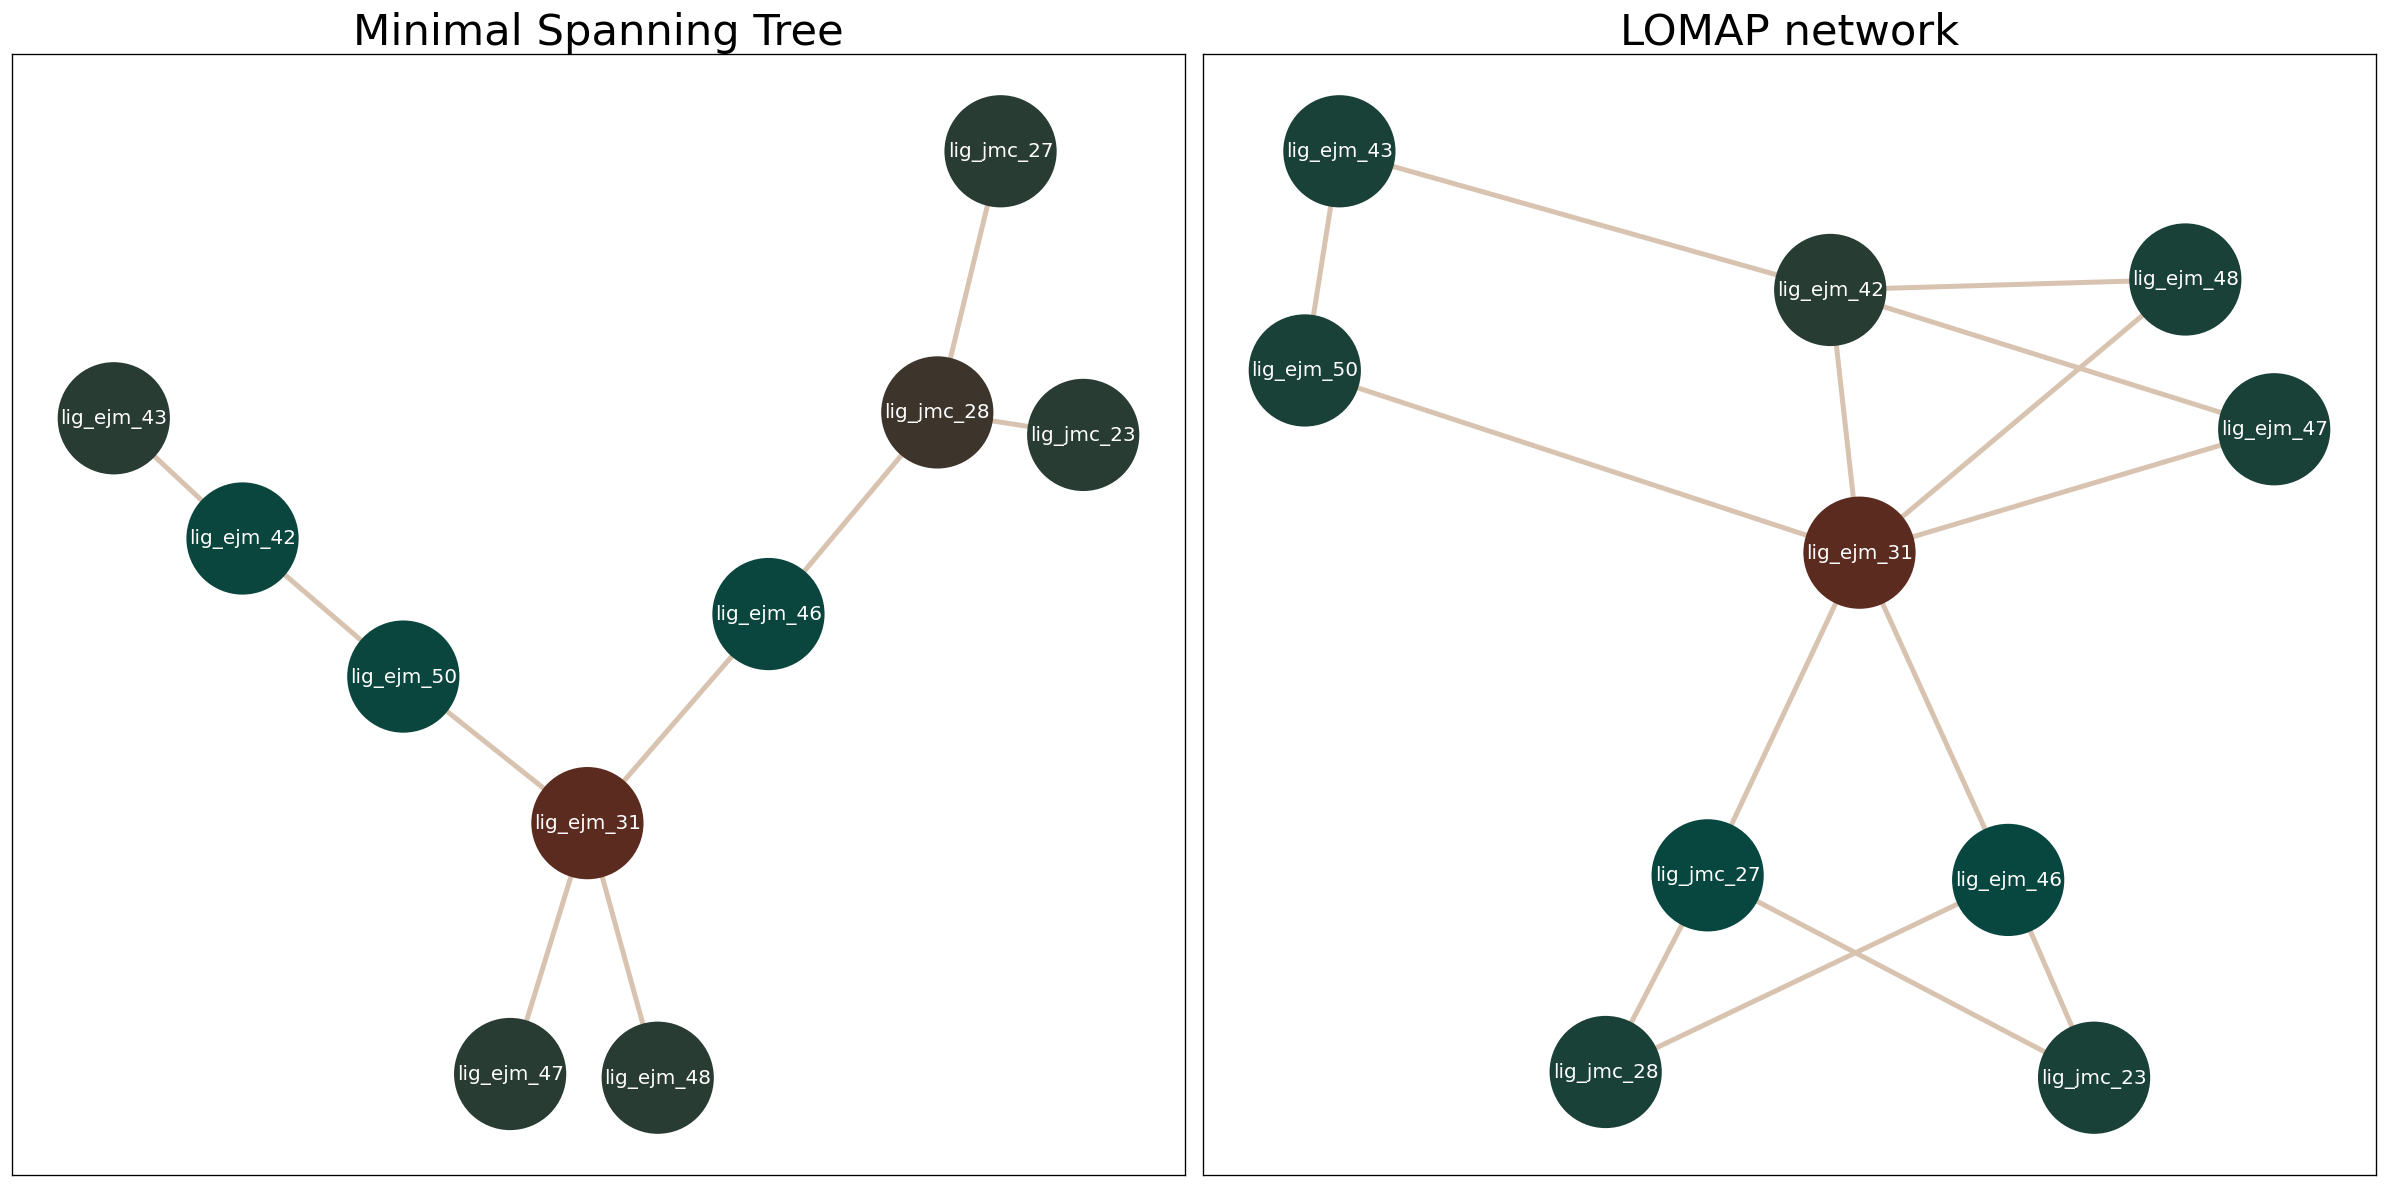

In [81]:
from konnektor.visualization import draw_ligand_network
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(20,10), dpi=120, squeeze=True)
draw_ligand_network(mst_network,node_size=4400, fontsize=26, title="Minimal Spanning Tree",ax=ax[0]);
draw_ligand_network(lomap_network,node_size=4400, fontsize=26, title="LOMAP network", ax=ax[1]);
fig.tight_layout()

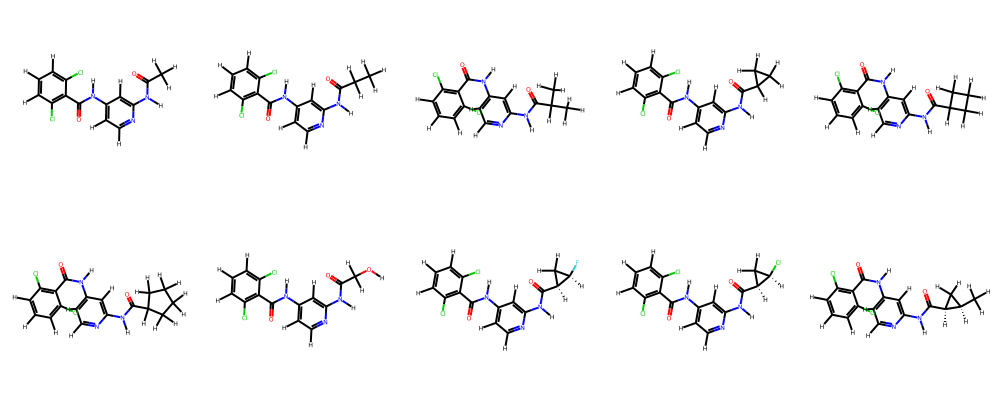

In [90]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# Extract the contents of the sdf file and visualise it
ligands_rdmol = [mol for mol in
                 Chem.SDMolSupplier('inputs/tyk2_ligands.sdf', removeHs=False)]

for ligand in ligands_rdmol:
    AllChem.Compute2DCoords(ligand)

Chem.Draw.MolsToGridImage(ligands_rdmol, molsPerRow=5)

Edges along the network can be accessed to recover the individual molecules involved in a given alchemical tranformation and the atom mapping between the two ligands. 

**Note: as can be seen in the example below, transformations are defined within OpenFE as going from componentA to componentB**

In [91]:
mst_edges = [edge for edge in mst_network.edges]

# Pick an edge
edge = mst_edges[1]

# Print the smiles of the molecules and the mapping
print("molecule A smiles: ", edge.componentA.smiles)
print("molecule B smiles: ", edge.componentB.smiles)
print("map between molecule A and B: ", edge.componentA_to_componentB)

molecule A smiles:  CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
molecule B smiles:  O=C(CO)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
map between molecule A and B:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 31: 29, 32: 30, 33: 31, 34: 32}


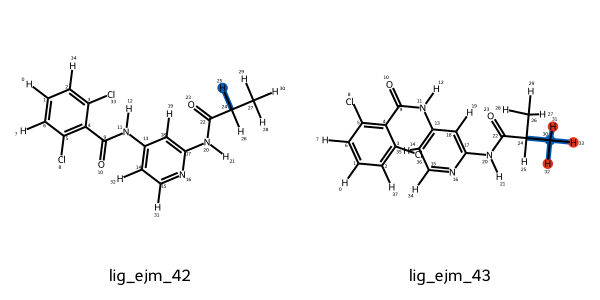

In [18]:
# We can display the atom mapping of an edge by calling it
edge

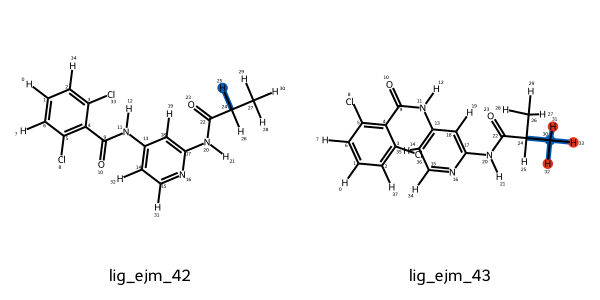

In [19]:
from IPython.display import Image

# mappings can also be saved to file if required
edge.draw_to_file('tyk2_edge.png')

# load it back for visualisation
Image("tyk2_edge.png")

#### Storing the ligand network

Created networks can easily be converted to (and also loaded from) a GraphML representation.

This can allow users of OpenFE to store the network to disk for later use.

In [92]:
# Convert to graphml
with open("network_store.graphml", "w") as writer:
    writer.write(mst_network.to_graphml())

### 2.1.4: Defining the Chemical Systems

`ChemicalSystems` are OpenFE containers which define the various components
in a system of interest. You can consider `ChemicalSystems` to be the nodes
along an alchemical network which are connected by edges which carry out
calculations along Alchemical states to get free energies.

`ChemicalSystems` take in:

1. A dictionary of the chemical components (e.g. `SmallMoleculeComponent`,
   `ProteinComponent`, `SolventComponent`) defining the system.

2. An identifier name (optional), for the `ChemicalSystem`. This is used as part
   of the hash identifier of the `ChemicalSystem`, and can help distinguish between
   otherwise comparable systems.

In the case of a relative ligand binding free energy calculation for `lig_ejm_31` -> `lig_ejm_47`,
four `ChemicalSystems` must be defined:

1. `lig_ejm_31` in complex with TYK2 in a box of water


2. `lig_ejm_47` in complex with TYK2 in a box of water


3. `lig_ejm_31` in a box of water


4. `lig_ejm_47` in a box of water


Here we will be passing the previously defined `SmallMoleculeComponents` for `lig_ejm_31`
and `lig_ejm_47`. We will also pass a `ProteinComponent` generated from the PDB file
present under `inputs/tyk2_protein.pdb`. Finally, instead of passing
in a specific box of water, we will define a `SolventComponent` which will contain
the necessary information for OpenMM's `Modeller` class to add water and 0.15 M NaCl
around the solute when creating the OpenMM simulation objects.

In [21]:
# First let's define the Protein and Solvent Components which we will be using
from openfe import SolventComponent, ProteinComponent
from openff.units import unit

protein = ProteinComponent.from_pdb_file('inputs/tyk2_protein.pdb')

# Note: the distance from the solute to add water is not defined here but in the
# the relevant RBFE solver method
solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                           neutralize=True, ion_concentration=0.15*unit.molar)

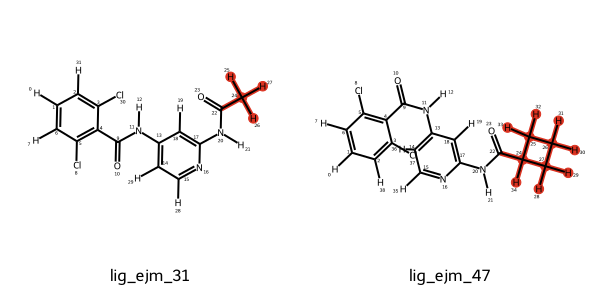

In [22]:
# Extract the relevant edge for the lig_ejm_31 -> lig_ejm_47 transform in the radial graph
ejm_31_to_ejm_47 = [edge for edge in mst_network.edges if edge.componentB.name == "lig_ejm_47"][0]

ejm_31_to_ejm_47

In [23]:
# Let's create the four ChemicalSystems
from openfe import ChemicalSystem

ejm_31_complex = ChemicalSystem(
    {'ligand': ejm_31_to_ejm_47.componentA, 'solvent': solvent, 'protein': protein},
    name=ejm_31_to_ejm_47.componentA.name,
)
ejm_31_solvent = ChemicalSystem(
    {'ligand': ejm_31_to_ejm_47.componentA,'solvent': solvent},
    name=ejm_31_to_ejm_47.componentA.name,
)
ejm_47_complex = ChemicalSystem(
    {'ligand': ejm_31_to_ejm_47.componentB, 'solvent': solvent, 'protein': protein},
    name=ejm_31_to_ejm_47.componentB.name,
)
ejm_47_solvent = ChemicalSystem(
    {'ligand': ejm_31_to_ejm_47.componentB,'solvent': solvent},
    name=ejm_31_to_ejm_47.componentB.name
)

### 2.1.5 Defining the RBFE simulation settings and protocol

Now that we have a set of atom mappings defined, we know which atoms should
undergo alchemical transformations to capture the free energy cost of
transforming from one ligand to another.

To simulate this transformation, we use the equilibrium RBFE protocol
implemented in OpenFE. This uses OpenMM to run a relative
ligand binding free energy calculation using a single topology approach.

The `RelativeHybridTopologyProtocol` class in `openfe.protocols.openmm_rfe`
implements a means to run the simulations above with minimal intervention.

Here we work through its usage for the `lig_ejm_31` -> `lig_ejm_47` binding free energy
test case. As this involves both a relative binding free energy in solvent
and complex phases, `RelativeHybridTopologyProtocol` will
be used to build two separate `ProtocolDAG` (directed-acyclic-graph) classes, one for each phase.
These `DAG`s (which contain the necessary individual simulations), are then executed to yield
the desired free energy results.

The `RelativeHybridTopologyProtocol` class can directly populate the above set of default
settings through its `default_settings` method.
Parameters can be overriden after creation.

In this case, we'll reduce the equilibration length to 0.01 * nanosecond
and the production to 0.05 * nanosecond in order to reduce the costs of
running this notebook (in practice, values of 1 and 5 nanoseconds,
respectively, would be most appropriate).

In [24]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
from openff.units import unit

# Create the default settings
rbfe_settings = RelativeHybridTopologyProtocol.default_settings()

rbfe_settings.simulation_settings.equilibration_length = 10 * unit.picosecond # Reduce equilibration length to 10 picoseconds
rbfe_settings.simulation_settings.production_length = 50 * unit.picosecond # Reduce prodution length to 50 picoseconds

rbfe_settings.simulation_settings

{'early_termination_target_error': <Quantity(0.0, 'kilocalorie_per_mole')>,
 'equilibration_length': <Quantity(0.01, 'nanosecond')>,
 'minimization_steps': 5000,
 'n_replicas': 11,
 'production_length': <Quantity(0.05, 'nanosecond')>,
 'real_time_analysis_interval': <Quantity(250, 'picosecond')>,
 'real_time_analysis_minimum_time': <Quantity(500, 'picosecond')>,
 'sampler_method': 'repex',
 'sams_flatness_criteria': 'logZ-flatness',
 'sams_gamma0': 1.0,
 'time_per_iteration': <Quantity(1, 'picosecond')>}


#### Creating the RBFE Protocol

With the Settings inspected and adjusted, we can provide these to the Protocol.
This Protocol defines the procedure to estimate a free energy difference between two chemical systems,
with the details of the two end states yet to be defined.

In [25]:
# Create RBFE Protocol class
rbfe_protocol = RelativeHybridTopologyProtocol(
    settings=rbfe_settings
)

### 2.1.6 Creating the Transformations

Once we have the ChemicalSystems and the Protocol, we can create the Transformation.

The `Transformation` requires as input:

* the two `ChemicalSystem` objects defining either end of the alchemical transformation (`stateA` and `stateB`)
* a mapping between the two systems
* the protocol
* a name (optional)

As previously detailed, we create two sets of transformations for the complex and the solvent legs of the thermodynamic cycle.

In [26]:
transformation_complex = openfe.Transformation(
            stateA=ejm_31_complex,
            stateB=ejm_47_complex,
            mapping=ejm_31_to_ejm_47,
            protocol=rbfe_protocol,  # use protocol created above
            name=f"{ejm_31_complex.name}_{ejm_47_complex.name}_complex"
        )
transformation_solvent = openfe.Transformation(
            stateA=ejm_31_solvent,
            stateB=ejm_47_solvent,
            mapping=ejm_31_to_ejm_47,
            protocol=rbfe_protocol,  # use protocol created above
            name=f"{ejm_31_solvent.name}_{ejm_47_solvent.name}_solvent"
        )

### Creating the `ProtocolDAG`

With the `Transformation` defined, we can move onto creating the `ProtocolDAG`.

The `Transformation.create()` method creates a directed-acyclic-graph (DAG) of computational tasks necessary for creating an estimate of the free energy difference between the two chemical systems.

In [27]:
complex_dag = transformation_complex.create()

solvent_dag = transformation_solvent.create()

The individual pieces of computational work are called Units. In this particular Protocol, the Units defined are three independent repeats of the alchemical transformation.

For other Protocols, for example non-equilibrium sampling routines, there might be dependencies between the tasks.

### Simulating the RelativeLigandTransforms

Individual Units can then be executed by calling the `.execute()` method.

In the first instance we do a dry-run (which does everything but
starting the simulation) to make sure that the
hybrid OpenMM system can be constructed without any issues.
Note: A successful call to `.run()` will return an empty Dictionary.

In [93]:
# complex dry-run
complex_unit = list(complex_dag.protocol_units)[0]
complex_unit.run(dry=True, verbose=True);

NameError: name 'complex_dag' is not defined

In [29]:
# solvent dry-run
solvent_unit = list(solvent_dag.protocol_units)[0]
solvent_unit.run(dry=True, verbose=True)

INFO:	Preparing the hybrid topology simulation
INFO:	Parameterizing molecules
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Requested to generate parameters for residue <Residue 0 (UNK) of chain 0>
INFO:	Creating hybrid system
INFO:	Setting force field terms
INFO:	Adding forces
INFO:	Hybrid system created
/Users/users_name/miniforge3/envs/openfe_env/lib/python3.12/site-packages/mdtraj/core/topology.py:84: UserWarning: atom_indices are not monotonically increasing
  warnings.warn("atom_indices are not monotonically increasing")
/Users/users_name/miniforge3/envs/openfe_env/lib/python3.12/site-packages/openfe/protocols/openmm_rfe/_rfe_utils/compute.py:56: UserWarning: Non-GPU platform selected: CPU, this may significantly impact simulation performance
  warnings.warn(wmsg)
INFO:	Creating and setting up the sampler


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

{'debug': {'sampler': <instance of HybridRepexSampler>}}

#### Simulating Using the CLI

Even when using the Python API to set up the RBFE calculations, you can dump all `Transformation`s to a JSON file and run the calculations using the `openfe quickrun` command. Here, we will show you how to save the `Transformation`s to the JSON file.

We’ll write out the transformation to disk, so that it can be run using the `openfe quickrun` command:

In [30]:
import pathlib
# first we create the directory
transformation_dir = pathlib.Path("tyk2_json")
transformation_dir.mkdir(exist_ok=True)

# then we write out the transformations
transformation_complex.dump(transformation_dir / f"{transformation_complex.name}.json")
transformation_solvent.dump(transformation_dir / f"{transformation_solvent.name}.json")

You can run the RBFE simulations from the CLI by using the `openfe quickrun` command, as described in Section 5. below.

## 2.3: Gather (and other analysis)

Finally now that we've "run" our simulations, let's go ahead and gather the free energies for both phases. 
With the CLI, we used `openfe gather` to do this. Here's how we can do the same thing, but with the flexibilty of Python:
### 2.3.1 Analysis

We can use the python API to gather the free energies for both phases by passing the results of executing the DAGs and calling the `gather()` methods of `RelativeLigandTransform`.
This takes a **list** of completed DAG results, catering for when simulations have been extended.

For production use we recommend saving the transformations to disk and using `openfe quickrun` to run them in an HPC environment, but for completeness, below is a python snippet that will run the transformations we defined earlier and then analyze the results. 

``` python
# Finally we can run the simulations
complex_path = pathlib.Path('./complex')
complex_path.mkdir()

# First the complex transformation
complex_dag_results = execute_DAG(complex_dag, scratch_basedir=complex_path, shared_basedir=complex_path)

# Next the solvent state transformation
solvent_path = pathlib.Path('./solvent')
solvent_path.mkdir()

solvent_dag_results = execute_DAG(solvent_dag, scratch_basedir=solvent_path, shared_basedir=solvent_path)

# Get the complex and solvent results
complex_results = rbfe_protocol.gather([complex_dag_results])
solvent_results = rbfe_protocol.gather([solvent_dag_results])

print(f"Complex dG: {complex_results.get_estimate()}, err {complex_results.get_uncertainty()}")
print(f"Solvent dG: {solvent_results.get_estimate()}, err {solvent_results.get_uncertainty()}")
```

# 3. Useful References for Exploring OpenFE Further

In our [documentation](https://docs.openfree.energy/en/latest/index.html), 
we provide tutorials for ever protocol to walk you through setup, execution and analysis step by step.

* [RBFE CLI tutorial](https://docs.openfree.energy/en/latest/tutorials/rbfe_cli_tutorial.html)
* [RBFE Python tutorial](https://docs.openfree.energy/en/latest/tutorials/rbfe_python_tutorial.html)
* [AHFE tutorial](https://docs.openfree.energy/en/latest/tutorials/ahfe_tutorial.html)
* [MD tutorial](https://docs.openfree.energy/en/latest/tutorials/md_tutorial.html)

In addition to the tutorials, you can find [cookbooks](https://docs.openfree.energy/en/latest/cookbook/index.html), written as How-to guides on how to utilize different components of the toolkit, as well as a [User Guide](https://docs.openfree.energy/en/latest/guide/index.html) that goes into the underlying concepts of the OpenFE toolkit.

For details about the toolkit's core methods and classes, please visit our [API Reference](https://docs.openfree.energy/en/latest/reference/index.html) or our [Github page](https://github.com/OpenFreeEnergy/openfe).

To learn more about the project, our team and how you can get involved, please visit our [Homepage](https://openfree.energy/) or get in touch at OpenFreeEnergy@omsf.io.